In [27]:
import torch
import random
import torchvision
import torch.nn as nn
import numpy as np
from PIL import Image
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from torchsummary import summary

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

mask_train = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1]]
mask_test = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1]]

train_loader = DataLoader(Subset(train_dataset, mask_train), batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(Subset(test_dataset, mask_test), batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [30]:
resnet50 = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)
resnet50 = resnet50.to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), weight_decay=1e-5)

In [33]:
num_epochs = 8

train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    resnet50.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}\t Accuracy: {correct / total * 100:.2f}%")
    train_loss_history.append(running_loss/len(train_loader))
    train_acc_history.append(correct / total)

Epoch 1/8, Loss: 0.2342	 Accuracy: 90.99%
Epoch 2/8, Loss: 0.1090	 Accuracy: 96.47%
Epoch 3/8, Loss: 0.0964	 Accuracy: 96.64%
Epoch 4/8, Loss: 0.0710	 Accuracy: 97.52%
Epoch 5/8, Loss: 0.0619	 Accuracy: 97.93%
Epoch 6/8, Loss: 0.0601	 Accuracy: 98.01%
Epoch 7/8, Loss: 0.0606	 Accuracy: 98.07%
Epoch 8/8, Loss: 0.0475	 Accuracy: 98.41%


In [34]:
torch.save(resnet50, 'resnet50_CE.pth')

In [58]:
resnet50.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet50(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 94.10%


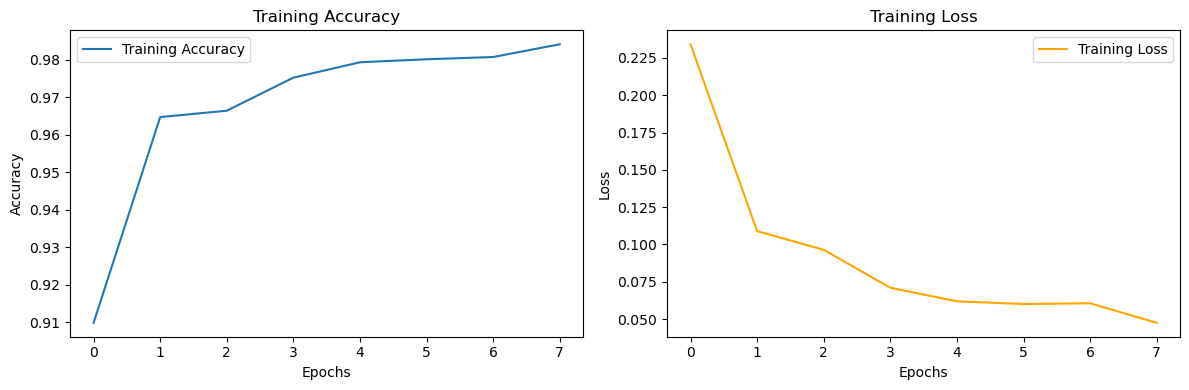

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
class ResNetFeatures(nn.Module):
    def __init__(self, original_model):
        super(ResNetFeatures, self).__init__()
        
        # Copy layers up to the fc layer from the original model
        self.conv1 = original_model.conv1
        self.bn1 = original_model.bn1
        self.relu = original_model.relu
        self.maxpool = original_model.maxpool
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2
        self.layer3 = original_model.layer3
        self.layer4 = original_model.layer4
        self.avgpool = original_model.avgpool

    def forward(self, x):
        # Forward pass through the copied layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        return x
    

class AssembledResNet(nn.Module):
    def __init__(self, featureExtractor):
        super(AssembledResNet, self).__init__()
        
        # Copy layers up to the fc layer from the original model
        self.conv1 = featureExtractor.conv1
        self.bn1 = featureExtractor.bn1
        self.relu = featureExtractor.relu
        self.maxpool = featureExtractor.maxpool
        self.layer1 = featureExtractor.layer1
        self.layer2 = featureExtractor.layer2
        self.layer3 = featureExtractor.layer3
        self.layer4 = featureExtractor.layer4
        self.avgpool = featureExtractor.avgpool
        self.fc = nn.Linear(2048, 2)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x
    
class BinaryCustomDataset(Dataset):

    def __init__(self, data, targets, classes, transform=None):
        super(BinaryCustomDataset, self).__init__()

        mask = [i for i in range(len(data)) if targets[i] in classes]
        self.data = data[mask]
        self.targets = np.array(targets, dtype=np.int64)[mask]
        self.classes = classes
        self.transform = transform
        self.subsets = []
        self.size = len(self.data)
        for i in classes:
            self.subsets.append([index for index, label in enumerate(self.targets) if label == i])

    
    def __len__(self):
            return len(self.data)
    
    def __getitem__(self, idx):
        
        cl = self.targets[idx]
        a = self.data[idx]
        p_id = random.choice(self.subsets[cl])
        p = self.data[(p_id + int(p_id == idx)) % self.size]
        n_id = random.choice(self.subsets[1-cl])
        n = self.data[n_id]

        a = Image.fromarray(a)
        p = Image.fromarray(p)
        n = Image.fromarray(n)
        
        if self.transform:
            a = self.transform(a)
            p = self.transform(p)
            n = self.transform(n)
        
        return (a, cl), (p, cl), (n, 1-cl)

In [47]:
resNetFeatures = ResNetFeatures(torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)).to(device)
binaryCustomDataset = BinaryCustomDataset(train_dataset.data, train_dataset.targets, [0, 1], transform=transform)

criterion = nn.TripletMarginLoss(margin=100., p=2)
optimizer = optim.Adam(resNetFeatures.parameters(), lr=30.)

In [48]:
loader = DataLoader(binaryCustomDataset, batch_size=256, shuffle=True)

num_epochs = 12
step_per_epoch = 150
train_loss_history = []

for epoch in range(num_epochs):
    resNetFeatures.train()

    running_loss = 0.0
    
    for _ in range(step_per_epoch):
        
        (a, _), (p, _), (n, _) = next(iter(loader))
        optimizer.zero_grad()

        f_a = resNetFeatures(a.to(device))
        f_p = resNetFeatures(p.to(device))
        f_n = resNetFeatures(n.to(device))

        loss = criterion(f_a, f_p, f_n)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs},\tLoss: {running_loss/step_per_epoch:.4f}")
    train_loss_history.append(running_loss/step_per_epoch)


Epoch 1/12,	Loss: 77.3101
Epoch 2/12,	Loss: 63.1333
Epoch 3/12,	Loss: 58.4745
Epoch 4/12,	Loss: 52.2882
Epoch 5/12,	Loss: 49.5470
Epoch 6/12,	Loss: 47.3690
Epoch 7/12,	Loss: 45.9016
Epoch 8/12,	Loss: 46.0169
Epoch 9/12,	Loss: 46.4023
Epoch 10/12,	Loss: 44.0721
Epoch 11/12,	Loss: 42.0763
Epoch 12/12,	Loss: 41.4234


In [50]:
torch.save(resNetFeatures, 'features.pth')

In [52]:
assembledResNet = AssembledResNet(resNetFeatures).to(device)

for name, params in assembledResNet.named_parameters():
    if not name.startswith('fc'):
        params.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(assembledResNet.fc.parameters(), lr=0.0011, weight_decay=1e-5)

In [53]:
num_epochs = 8

train_loss_history = []
train_acc_history = []


for epoch in range(num_epochs):
    assembledResNet.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = assembledResNet(inputs)
        _, predicted = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}\t Accuracy: {correct / total * 100:.2f}%")
    train_loss_history.append(running_loss/len(train_loader))
    train_acc_history.append(correct / total)

Epoch 1/8, Loss: 18.7111	 Accuracy: 93.59%
Epoch 2/8, Loss: 15.8725	 Accuracy: 95.36%
Epoch 3/8, Loss: 14.7720	 Accuracy: 95.93%
Epoch 4/8, Loss: 21.3701	 Accuracy: 95.25%
Epoch 5/8, Loss: 9.5316	 Accuracy: 95.78%
Epoch 6/8, Loss: 16.7857	 Accuracy: 95.31%
Epoch 7/8, Loss: 21.4734	 Accuracy: 95.32%
Epoch 8/8, Loss: 12.5610	 Accuracy: 95.02%


In [54]:
torch.save(assembledResNet, 'resnet50_TL.pth')

In [56]:
assembledResNet.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = assembledResNet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


accuracy = correct / total
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 95.70%


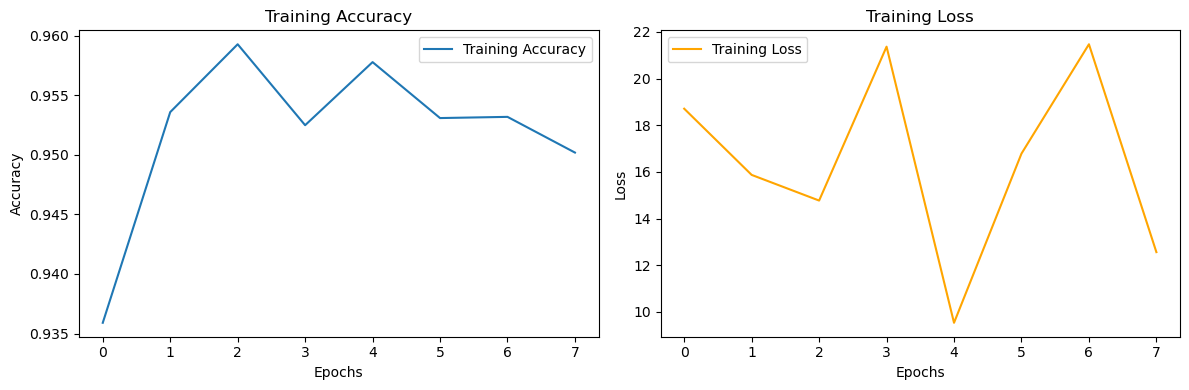

In [57]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
resnetHybrid = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
resnetHybrid.fc = nn.Linear(resnetHybrid.fc.in_features, 2)
resnetHybrid = resnetHybrid.to(device)

binaryCustomDataset = BinaryCustomDataset(train_dataset.data, train_dataset.targets, [0, 1], transform=transform)


In [24]:
L_ce = nn.CrossEntropyLoss()
L_tr = nn.TripletMarginLoss()
optimizer = optim.Adam(resnetHybrid.parameters(), weight_decay=1e-5)

In [25]:
loader = DataLoader(binaryCustomDataset, batch_size=64, shuffle=True)

num_epochs = 8

train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):

    resnetHybrid.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for (a, l_a), (p, l_p), (n, l_n) in loader:

        optimizer.zero_grad()

        f_a = resnetHybrid(a.to(device))
        f_p = resnetHybrid(p.to(device))
        f_n = resnetHybrid(n.to(device))

        outputs = torch.cat((f_a, f_p, f_n), dim=0)
        _, predicted = torch.max(outputs, 1)

        labels = torch.cat((l_a, l_p, l_n), dim=0).to(device)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = L_tr(f_a, f_p, f_n) + L_ce(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs},\tLoss: {running_loss/len(loader):.4f},\tAccuracy: {correct / total * 100:.2f}%")
    
    train_loss_history.append(running_loss/len(loader))
    train_acc_history.append(correct / total)


Epoch 1/8,	Loss: 0.5949,	Accuracy: 90.88%
Epoch 2/8,	Loss: 0.2517,	Accuracy: 96.99%
Epoch 3/8,	Loss: 0.1732,	Accuracy: 97.81%
Epoch 4/8,	Loss: 0.1331,	Accuracy: 98.21%
Epoch 5/8,	Loss: 0.1245,	Accuracy: 98.37%
Epoch 6/8,	Loss: 0.0908,	Accuracy: 98.74%
Epoch 7/8,	Loss: 0.0969,	Accuracy: 98.52%
Epoch 8/8,	Loss: 0.0953,	Accuracy: 98.69%


In [59]:
torch.save(resnetHybrid, 'resnet50_CE_TL.pth')

In [26]:
resnetHybrid.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnetHybrid(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Accuracy on test set: 97.70%


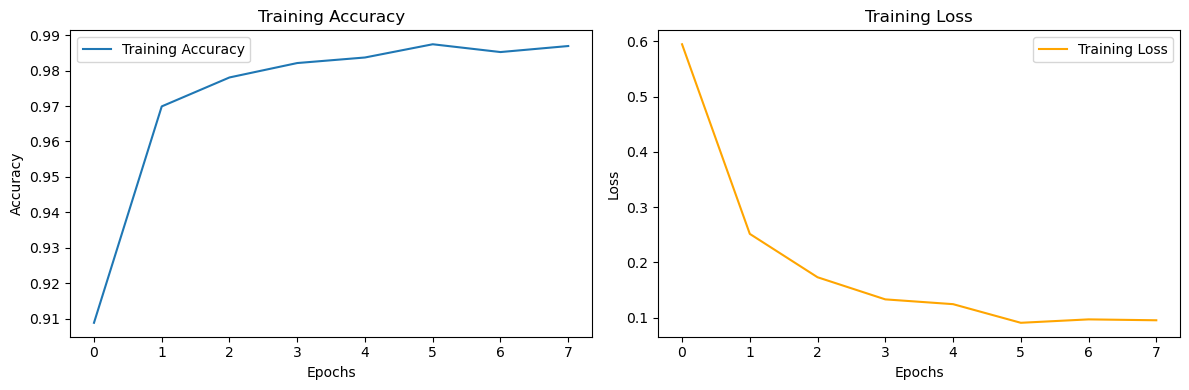

In [32]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()